### **Tutorial Group**: FCSF 
### **Group 1**: Clarence, Huzairi, Hym Leong

---

## **ComforTrain**

Develop a system that recommends the most affordable route within the Singapore Public Transport System while prioritizing passenger comfort, defined as having a seat available and minimizing passenger volume on trains or buses.

![MRTimage](http://journey.smrt.com.sg/static/journey/img/network_map_2022_November.png "image1")

To execute this, we can manipulate on:
- the number of people in each train by gathering the number of trips made from 1 station to another
- the time of these trips that were made
- the type of day; whether it is a weekday, weekend or a holiday


---

Here is the link for our video presentation **here**

### **Essential Libraries**

Let us begin by importing the essential Python Libraries.

---

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import math
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import heatmap
import datetime

### **Reading of the dataset in CSV**

For the dataset, we will be manipulating it from Singapore's Land Transport Authority DataMall API for the Passenger Volume by Origin Destination Train Stations. To obtain this data, we call an API from it to obtain our datasets.


In [2]:
##df_dec23 = pd.read_csv('/content/drive/My Drive/SC1015 Excel Files/origin_destination_train_202312.csv')
##df_jan24 = pd.read_csv('/content/drive/My Drive/SC1015 Excel Files/origin_destination_train_202401.csv')
##df_feb24 = pd.read_csv('/content/drive/My Drive/SC1015 Excel Files/origin_destination_train_202402.csv')

df_dec23 = pd.read_csv("RawFiles/202312_RawDataset.csv")
df_jan24 = pd.read_csv("RawFiles/202401_RawDataset.csv")
df_feb24 = pd.read_csv("RawFiles/202402_RawDataset.csv")
df_mar24 = pd.read_csv("RawFiles/202402_RawDataset.csv")

In [3]:
df_dec23.head()

YEAR_MONTH          DAY_TYPE  TIME_PER_HOUR PT_TYPE ORIGIN_PT_CODE  \
0    2023-12  WEEKENDS/HOLIDAY             13   TRAIN           NS19   
1    2023-12  WEEKENDS/HOLIDAY             13   TRAIN           NE11   
2    2023-12           WEEKDAY             13   TRAIN           NE11   
3    2023-12           WEEKDAY             13   TRAIN           NS19   
4    2023-12  WEEKENDS/HOLIDAY             14   TRAIN            NS8   

  DESTINATION_PT_CODE  TOTAL_TRIPS  
0                NE11           10  
1                NS19           26  
2                NS19           27  
3                NE11           22  
4            CC4/DT15           22

### **Data Description**:            

>**YEAR_MONTH:**             Year & Month of travel.
>
>**DAY_TYPE:**               Weekday OR Weekend/Holiday.
>
>**TIME_PER_HOUR:**          Time in 24 hours.
>
>**PT_TYPE:**                Transportation Mode.
>
>**ORIGIN_PT_CODE:**         Origin MRT alpha-numeric code (e.g. EW1 refers to the East–West Line, Pasir Ris station)
>
>**DESTINATION_PT_CODE:**    Destination MRT alpha-numeric code (e.g. EW1 refers to the East–West Line, Pasir Ris station)
>
>**TOTAL_TRIPS:**            Number of trips from Origin to Destination during ht month of Janurary.

---

### **Data Preparation and Cleaning**: (10%)            
We must ensure that the dataset is thoroughly cleaned and prepared before proceeding on with our data exploration.

We first collect the data through API call to DataMall by LTA.
To prepare the DataSet, 

We then combined all the datasets into a single DataFrame by concatenating them.

We then iterate over each dataset to check for any missing where there isn't any.


---

We incorporated 2 functions into our dataset to refine it which are mainLoad and subLoad so as to calculate the passenger loads that is done on each MRT line.

the mainLoad is to calculate all passengers on the same line where it takes the origin station and calculate both directions load and creates a new dataset based on time and line for each direction.

the subLoad is to calculate all passenger on the sub lines heading to the same direction.

In [4]:
# Combine all datasets into a single DataFrame
datasets = [df_dec23, df_jan24, df_feb24]
combined_df = pd.concat(datasets, ignore_index=True)

# Initialize an empty dictionary to store missing value counts for each dataset
missing_values_counts = {}

# Iterate over each dataset and check for missing values
for i, df in enumerate(datasets, start=1):
    missing_values_counts[f"Dataset_{i}"] = df.isnull().sum()

# Combine the missing value counts into a single DataFrame
missing_values_df = pd.DataFrame(missing_values_counts)

print(missing_values_df)

                     Dataset_1  Dataset_2  Dataset_3
YEAR_MONTH                   0          0          0
DAY_TYPE                     0          0          0
TIME_PER_HOUR                0          0          0
PT_TYPE                      0          0          0
ORIGIN_PT_CODE               0          0          0
DESTINATION_PT_CODE          0          0          0
TOTAL_TRIPS                  0          0          0


In [5]:
#Preperation

EW_STATIONS = [
    "EW1", "EW2/DT32", "EW3", "EW4", "EW5", "EW6", "EW7", "EW8/CC9", "EW9", "EW10",
    "EW11", "EW12/DT14", "NS25/EW13", "EW14/NS26", "EW15", "EW16/NE3/TE17", "EW17", "EW18", "EW19", "EW20",
    "EW21/CC22", "EW22", "EW23", "EW24/NS1", "EW25", "EW26", "EW27", "EW28", "EW29", "EW30",
    "EW31", "EW32", "EW33"
]  

# Define all EW line stations
EW_STATIONS_NAME = [
    "Pasir Ris","Tampines","Simei","Tanah Merah","Bedok","Kembangan","Eunos","Paya Lebar","Aljunied","Kallang",
    "Lavender", "Bugis", "City Hall", "Raffles Place", "Tanjong Pagar", "Outram Park", "Tiong Bahru", "Redhill",
    "Queenstown", "Commonwealth", "Buona Vista", "Dover", "Clementi", "Jurong East", "Chinese Garden", "Lakeside",
    "Boon Lay", "Pioneer", "Joo Koon", "Gul Circle", "Tuas Crescent", "Tuas West Road", "Tuas Link",
]

NS_STATIONS = [
    "EW24/NS1","NS2","NS3","NS4/BP1","NS5","NS6","NS7","NS8","NS9/TE2","NS10","NS11","NS12","NS13","NS14",
    "NS15","NS16","NS17/CC15","NS18","NS19","NS20","NS21/DT11","TE14/NS22","NS23","NS24/NE6/CC1","NS25/EW13",
    "EW14/NS26","NS27/CE2/TE20","NS28",
]

NS_STATIONS_NAME = [
    "Jurong East","Bukit Batok","Bukit Gombak","Choa Chu Kang","Yew Tee","Unused Station","Kranji","Marsiling",
    "Woodlands", "Admiralty", "Sembawang", "Canberra", "Yishun", "Khatib", "Yio Chu Kang", "Ang Mo Kio", "Bishan",
    "Braddell", "Toa Payoh", "Novena", "Newton", "Orchard", "Somerset", "Dhoby Ghaut", "City Hall", "Raffles Place",
    "Marina Bay",  "Marina South Pier",
]

NE_STATIONS = [
    "NE1/CC29", "NE2", "EW16/NE3/TE17", "NE4/DT19", "NE5", "NS24/NE6/CC1", "NE7/DT12", "NE8",
    "NE9", "NE10", "NE11", "NE12/CC13",  "NE13", "NE14", "NE15", "NE16/STC", "NE17/PTC",
]
NE_STATIONS_NAME = [
    "Harbourfront", "Unused Station", "Outram Park", "Chinatown", "Clarke Quay", "Dhoby Ghaut", "Little India", "Farrer Park",
    "Boon Keng", "Potong Pasir", "Woodleigh", "Serangoon", "Kovan", "Hougang", "Buangkok", "Sengkang", "Punggol",
]

CC_STATIONS = [
    "NS24/NE6/CC1", "CC2", "CC3", "CC4/DT15", "CC5", "CC6", "CC7", "CC8", "EW8/CC9", "CC10", "CC11", 
    "CC12", "NE12/CC13", "CC14", "NS17/CC15", "CC16", "CC17/TE9", "CC18", "CC19/DT9", "CC20", "CC21",
    "EW21/CC22", "CC23", "CC24", "CC25", "CC26", "CC27", "CC28", "NE1/CC29",
]

CC_STATIONS_NAME = [
    "Dhoby Ghaut", "Bras Basah", "Esplanade", "Promenade", "Nicoll Highway", "Stadium", "Mountbatten", "Dakota",
    "Paya Lebar", "Macpherson", "Tai Seng", "Bartley", "Serangoon", "Lorong Chuan", "Bishan", "Marymount",
    "Caldecott",  "N/A",  "Botanic Garden",  "Farrer Road",  "Holland Village", "Buona Vista", "one-north", 
    "Kent Ridge", "Haw Par Villa", "Pasir Panjang", "Labrador Park", "Telok Blangah", "Harbourfront",
]

DT_STATIONS = [
    "BP6/DT1", "DT2", "DT3", "DT4", "DT5", "DT6", "DT7", "DT8", "CC19/DT9", "DT10/TE11", "NS21/DT11", "NE7/DT12",
    "DT13", "EW12/DT14", "CC4/DT15", "CE1/DT16", "DT17", "DT18", "NE4/DT19", "DT20", "DT21", "DT22", "DT23",
    "DT24", "DT25", "CC10/DT26", "DT27", "DT28", "DT29", "DT30", "DT31", "EW2/DT32", "DT33", "DT34", "CG1/DT35"
]
DT_STATIONS_NAME = [
    "Bukit Panjang", "Cashew", "Hillview", "N/A", "Beauty World", "King Albert Park", "Sixth Avenue", "Tan Kah Kee",
    "Botanic Gardens", "Stevens", "Newton", "Little India", "Rochor", "Bugis", "Promenade", "Bayfront", "Downtown",
    "Telok Ayer", "Chinatown", "Fort Canning", "Bencoolen", "Jalan Besar", "Bendemeer", "Geylang Bahru", "Mattar", 
    "MacPherson", "Ubi", "Kaki Bukit", "Bedok North", "Bedok Reservoir", "Tampines West", "Tampines", "Tampines East",
    "Upper Changi", "Expo",
]

TE_STATIONS = [
    "TE1", "NS9/TE2", "TE3", "TE4", "TE5", "TE6", "TE7", "TE8", "CC17/TE9", "TE10", "DT10/TE11", "TE12",
    "TE13", "TE14/NS22", "TE15", "TE16", "EW16/NE3/TE17", "TE18", "TE19", "NS27/CE2/TE20", "TE21", "TE22",
]

TE_STATIONS_NAME = [
    "Woodlands North", "Woodlands", "Woodlands South", "Springleaf", "Lentor", "Mayflower", "Bright Hill",
    "Caldecott", "N/A", "Stevens", "Napier", "Orchard Boulevard", "Orchard", "Great World", "Havelock",
    "Outram Park", "Maxwell", "Shenton Way", "Marina Bay", "N/A", "Gardens by the Bay",
]

INTERCHANGES = [
    "EW2/DT32", "EW8/CC9", "EW12/DT14", "NS25/EW13", "EW14/NS26",
    "EW16/NE3/TE17", "EW21/CC22", "EW24/NS1", "NS4/BP1", "NS9/TE2",
    "NS17/CC15", "NS21/DT11", "TE14/NS22", "NS24/NE6/CC1", "NS27/CE2/TE20",
    "NE1/CC29", "NE7/DT12", "NE12/CC13", "NE16/STC", "NE17/PTC",
    "CC4/DT15", "CC17/TE9", "CC19/DT9", "BP6/DT1", "DT10/TE11"
]

# We need to define all the stations along the same line.

EW_LINE = [ "EW1", "EW2", "EW3", "EW4", "EW5", "EW6", "EW7", "EW8", "EW9", "EW10", "EW11", "EW12", "EW13", "EW14", "EW15", "EW16", "EW17", "EW18", "EW19", "EW20", "EW21", "EW22", "EW23", "EW24", "EW25", "EW26", "EW27", "EW28", "EW29", "EW30", "EW31", "EW32", "EW33"]
NS_LINE = [ "NS1", "NS2", "NS3", "NS4", "NS5", "NS6", "NS7", "NS8", "NS9", "NS10", "NS11", "NS12", "NS13", "NS14", "NS15", "NS16", "NS17", "NS18", "NS19", "NS20", "NS21", "NS22", "NS23", "NS24", "NS25", "NS26", "NS27", "NS28"]
NE_LINE = [ "NE1", "NE2", "NE3", "NE4", "NE5", "NE6", "NE7", "NE8", "NE9", "NE10", "NE11", "NE12", "NE13", "NE14", "NE15", "NE16", "NE17"]
CC_LINE = [ "CC1", "CC2", "CC3", "CC4", "CC5", "CC6", "CC7", "CC8", "CC9", "CC10", "CC11", "CC12", "CC13", "CC14", "CC15", "CC16", "CC17", "CC18", "CC19", "CC20", "CC21", "CC22", "CC23", "CC24", "CC25", "CC26", "CC27", "CC28", "CC29"]
DT_LINE = [ "DT1", "DT2", "DT3", "DT4", "DT5", "DT6", "DT7", "DT8", "DT9", "DT10", "DT11", "DT12", "DT13", "DT14", "DT15", "DT16", "DT17", "DT18", "DT19", "DT20", "DT21", "DT22", "DT23", "DT24", "DT25", "DT26", "DT27", "DT28", "DT29", "DT30", "DT31", "DT32", "DT33", "DT34", "DT35"]
TE_LINE = [ "TE1", "TE2", "TE3", "TE4", "TE5", "TE6", "TE7", "TE8", "TE9", "TE10", "TE11", "TE12", "TE13", "TE14", "TE15", "TE16", "TE17", "TE18", "TE19", "TE20", "TE21", "TE22"]

In [6]:
# Functions to calculate passenger loads: mainLoad(), subLoad()

# mainLoad() is to calculate all passengers on the same line.
def mainLoad(data, lineList, origin):
     # Takes in the origin station and calculates both directions load.
    stations_checked = []
    # For Direction 1: (Station Code in Ascending Order)
    stations_before_origin = lineList[:origin]
    stations_after_origin = lineList[origin:]

    # Creates the newest dataset based on time and line:
    direction1_cases = data[(data["ORIGIN_PT_CODE"].isin(stations_before_origin)) & (data["DESTINATION_PT_CODE"].isin(stations_after_origin))]
    direction1_load = direction1_cases["TOTAL_TRIPS"].sum()

    for station in stations_before_origin:
        if station in INTERCHANGES:
            if ((station in EW_STATIONS) & (lineList != EW_STATIONS) & ((EW_STATIONS in stations_checked) == False)):
                index = EW_STATIONS.index(station)
                stations_checked.append(EW_STATIONS)
                sector1, sector2 = subLoad(data, EW_STATIONS, index + 1, stations_after_origin)
                direction1_load += sector1 + sector2
            if ((station in NS_STATIONS) & (lineList != NS_STATIONS) & ((NS_STATIONS in stations_checked) == False)):
                index = NS_STATIONS.index(station)
                stations_checked.append(NS_STATIONS)
                sector1, sector2 = subLoad(data, NS_STATIONS, index + 1, stations_after_origin)
                direction1_load += sector1 + sector2
            if ((station in NE_STATIONS) & (lineList != NE_STATIONS) & ((NE_STATIONS in stations_checked) == False)):
                index = NE_STATIONS.index(station)
                stations_checked.append(NE_STATIONS)
                sector1, sector2 = subLoad(data, NE_STATIONS, index + 1, stations_after_origin)
                direction1_load += sector1 + sector2
            if ((station in CC_STATIONS) & (lineList != CC_STATIONS) & ((CC_STATIONS in stations_checked) == False)):
                index = CC_STATIONS.index(station)
                stations_checked.append(CC_STATIONS)
                sector1, sector2 = subLoad(data, CC_STATIONS, index + 1, stations_after_origin)
                direction1_load += sector1 + sector2
            if ((station in DT_STATIONS) & (lineList != DT_STATIONS) & ((DT_STATIONS in stations_checked) == False)):
                index = DT_STATIONS.index(station)
                stations_checked.append(DT_STATIONS)
                sector1, sector2 = subLoad(data, DT_STATIONS, index + 1, stations_after_origin)
                direction1_load += sector1 + sector2
            if ((station in TE_STATIONS) & (lineList != TE_STATIONS) & ((TE_STATIONS in stations_checked) == False)):
                index = TE_STATIONS.index(station)
                stations_checked.append(TE_STATIONS)
                sector1, sector2 = subLoad(data, TE_STATIONS, index + 1, stations_after_origin)
                direction1_load += sector1 + sector2

    stations_checked = []
    # For Direction 2: (Stations in Descending Order)
    stations_before_origin = lineList[origin-1:]
    stations_after_origin = lineList[:origin-1]
    
    # Creates the newest dataset based on time and line:
    direction2_cases = data[(data["ORIGIN_PT_CODE"].isin(stations_before_origin)) & (data["DESTINATION_PT_CODE"].isin(stations_after_origin))]
    direction2_load = direction2_cases["TOTAL_TRIPS"].sum()

    for station in stations_before_origin:
        if station in INTERCHANGES:
            if ((station in EW_STATIONS) & (lineList != EW_STATIONS) & ((EW_STATIONS in stations_checked) == False)):
                index = EW_STATIONS.index(station)
                stations_checked.append(EW_STATIONS)
                sector1, sector2 = subLoad(data, EW_STATIONS, index + 1, stations_after_origin)
                direction2_load += sector1 + sector2
            if ((station in NS_STATIONS) & (lineList != NS_STATIONS) & ((NS_STATIONS in stations_checked) == False)):
                index = NS_STATIONS.index(station)
                stations_checked.append(NS_STATIONS)
                sector1, sector2 = subLoad(data, NS_STATIONS, index + 1, stations_after_origin)
                direction2_load += sector1 + sector2
            if ((station in NE_STATIONS) & (lineList != NE_STATIONS) & ((NE_STATIONS in stations_checked) == False)):
                index = NE_STATIONS.index(station)
                stations_checked.append(NE_STATIONS)
                sector1, sector2 = subLoad(data, NE_STATIONS, index + 1, stations_after_origin)
                direction2_load += sector1 + sector2
            if ((station in CC_STATIONS) & (lineList != CC_STATIONS) & ((CC_STATIONS in stations_checked) == False)):
                index = CC_STATIONS.index(station)
                stations_checked.append(CC_STATIONS)
                sector1, sector2 = subLoad(data, CC_STATIONS, index + 1, stations_after_origin)
                direction2_load += sector1 + sector2
            if ((station in DT_STATIONS) & (lineList != DT_STATIONS) & ((DT_STATIONS in stations_checked) == False)):
                index = DT_STATIONS.index(station)
                stations_checked.append(DT_STATIONS)
                sector1, sector2 = subLoad(data, DT_STATIONS, index + 1, stations_after_origin)
                direction2_load += sector1 + sector2
            if ((station in TE_STATIONS) & (lineList != TE_STATIONS) & ((TE_STATIONS in stations_checked) == False)):
                index = TE_STATIONS.index(station)
                stations_checked.append(TE_STATIONS)
                sector1, sector2 = subLoad(data, TE_STATIONS, index + 1, stations_after_origin)
                direction2_load += sector1 + sector2

    return (direction1_load, direction2_load)

# subLoad() is to calculate all passengers on the sub lines heading same directions.
def subLoad(data, lineList, origin, end):
    # print(origin)
    if all(station in end for station in lineList):
        return 0, 0

    # For Section 1: (Platform A - Stations before the origin interchanges)
    stations_before_origin = lineList[origin-math.floor(origin/2):origin - 1]
    stations_after_origin = lineList[origin:origin+math.floor(origin/2)]

    direction1_cases = data[(data["ORIGIN_PT_CODE"].isin(stations_before_origin)) & (data["DESTINATION_PT_CODE"].isin(end))]
    direction1_load = direction1_cases["TOTAL_TRIPS"].sum()

    # For Direction 2: (Platform B - Stations after the origin interchanges)
    direction2_cases = data[(data["ORIGIN_PT_CODE"].isin(stations_after_origin)) & (data["DESTINATION_PT_CODE"].isin(end))]
    direction2_load = direction2_cases["TOTAL_TRIPS"].sum()

    return (direction1_load, direction2_load)

In [8]:
# Function to generate Dataset
def generateDataSet(input_file, output_file):

    source_data = pd.read_csv(input_file)

    newData = pd.DataFrame(columns=['WeekType', 'Time', 'Station', 'Direction1', 'Direction2'])

    for type in ["WEEKDAY", "WEEKENDS/HOLIDAY"]:

        # We have to split the raw data file into 2 sections: Weekdays and Weekends/Holidays.
        section_data = source_data[source_data["DAY_TYPE"] == type]

        for time in range(0,24):

            timed_data = section_data[section_data["TIME_PER_HOUR"] == time]

            for station in EW_STATIONS:
                station_code = EW_STATIONS.index(station)

                main1A, main1B = mainLoad(timed_data, EW_STATIONS, EW_STATIONS.index(station)+1)
                
                new_row = {'WeekType': type, 'Time': time, 'Station': EW_LINE[station_code], 'Direction1': main1A, 'Direction2': main1B}
                # Append the new row to the new DataFrame
                new = pd.DataFrame([new_row])
                newData = pd.concat([newData, new], ignore_index=True)

            for station in NS_STATIONS:
                station_code = NS_STATIONS.index(station)

                main1A, main1B = mainLoad(timed_data, NS_STATIONS, NS_STATIONS.index(station)+1)
                
                new_row = {'WeekType': type, 'Time': time, 'Station': NS_LINE[station_code], 'Direction1': main1A, 'Direction2': main1B}
                # Append the new row to the new DataFrame
                new = pd.DataFrame([new_row])
                newData = pd.concat([newData, new], ignore_index=True)

            for station in NE_STATIONS:
                station_code = NE_STATIONS.index(station)

                main1A, main1B = mainLoad(timed_data, NE_STATIONS, NE_STATIONS.index(station)+1)
                
                new_row = {'WeekType': type, 'Time': time, 'Station': NE_LINE[station_code], 'Direction1': main1A, 'Direction2': main1B}
                # Append the new row to the new DataFrame
                new = pd.DataFrame([new_row])
                newData = pd.concat([newData, new], ignore_index=True)

            for station in CC_STATIONS:
                station_code = CC_STATIONS.index(station)

                main1A, main1B = mainLoad(timed_data, CC_STATIONS, CC_STATIONS.index(station)+1)
                
                new_row = {'WeekType': type, 'Time': time, 'Station': CC_LINE[station_code], 'Direction1': main1A, 'Direction2': main1B}
                # Append the new row to the new DataFrame
                new = pd.DataFrame([new_row])
                newData = pd.concat([newData, new], ignore_index=True)

            for station in DT_STATIONS:
                station_code = DT_STATIONS.index(station)

                main1A, main1B = mainLoad(timed_data, DT_STATIONS, DT_STATIONS.index(station)+1)
                
                new_row = {'WeekType': type, 'Time': time, 'Station': DT_LINE[station_code], 'Direction1': main1A, 'Direction2': main1B}
                # Append the new row to the new DataFrame
                new = pd.DataFrame([new_row])
                newData = pd.concat([newData, new], ignore_index=True)

            for station in TE_STATIONS:
                station_code = TE_STATIONS.index(station)

                main1A, main1B = mainLoad(timed_data, TE_STATIONS, TE_STATIONS.index(station)+1)
                
                new_row = {'WeekType': type, 'Time': time, 'Station': TE_STATIONS[station_code], 'Direction1': main1A, 'Direction2': main1B}
                # Append the new row to the new DataFrame
                new = pd.DataFrame([new_row])
                newData = pd.concat([newData, new], ignore_index=True)


    newData.to_csv(output_file)
    print("Successful conversion of Dataset!")

generateDataSet("RawFiles/202403_RawDataset.csv", "202403_Dataset.csv")
generateDataSet("RawFiles/202402_RawDataset.csv", "202402_Dataset.csv")
generateDataSet("RawFiles/202401_RawDataset.csv", "202401_Dataset.csv")
generateDataSet("RawFiles/202312_RawDataset.csv", "202312_Dataset.csv")

Successful conversion of Dataset!
Successful conversion of Dataset!
Successful conversion of Dataset!
Successful conversion of Dataset!


In [9]:
data1 = pd.read_csv("202312_Dataset.csv")
data2 = pd.read_csv("202401_Dataset.csv")
data3 = pd.read_csv("202402_Dataset.csv")
data4 = pd.read_csv("202403_Dataset.csv")

---
### **Data Exploration & Analysis**:    

We have gathered the number of trips across 6 MRT Networks consisting of 183 Stations. This has helped us to gain insights on the number of people between one station to another.

The obtained dataset was recorded from December 2023 to February 2024, on all types of days and at each hour intervals for each of the days.

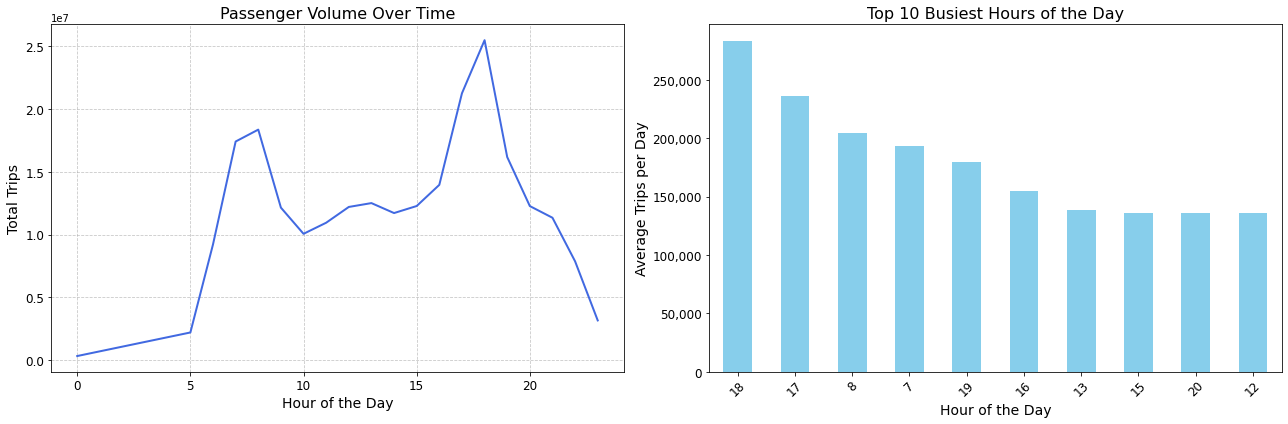

In [10]:
from matplotlib.ticker import FuncFormatter

# Calculate the top 10 busiest hours divided by an average of 30 days per month, further divided by 3 months (3 datasets)
peak_hours = combined_df.groupby('TIME_PER_HOUR')['TOTAL_TRIPS'].sum().sort_values(ascending=False).head(10) / 30 / 3

# Calculate the total trips per hour
total_trips_per_hour = combined_df.groupby('TIME_PER_HOUR')['TOTAL_TRIPS'].sum().reset_index()

# Set up the figure and axes for subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# Plot passenger volume over time with summed total trips
sns.lineplot(data=total_trips_per_hour, x='TIME_PER_HOUR', y='TOTAL_TRIPS', linewidth=2, color='royalblue', ax=axes[0])

# Add titles and labels for the first plot
axes[0].set_title('Passenger Volume Over Time', fontsize=16)
axes[0].set_xlabel('Hour of the Day', fontsize=14)
axes[0].set_ylabel('Total Trips', fontsize=14)
axes[0].tick_params(axis='x', labelsize=12)
axes[0].tick_params(axis='y', labelsize=12)
axes[0].grid(True, linestyle='--', alpha=0.7)

# Plot the top 10 busiest hours as a bar plot
peak_hours.plot(kind='bar', color='skyblue', ax=axes[1])

# Add titles and labels for the second plot
axes[1].set_title('Top 10 Busiest Hours of the Day', fontsize=16)
axes[1].set_xlabel('Hour of the Day', fontsize=14)
axes[1].set_ylabel('Average Trips per Day', fontsize=14)
axes[1].tick_params(axis='x', labelrotation=45, labelsize=12)
axes[1].tick_params(axis='y', labelsize=12)

# Format y-axis labels to display average trips per day
axes[1].yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

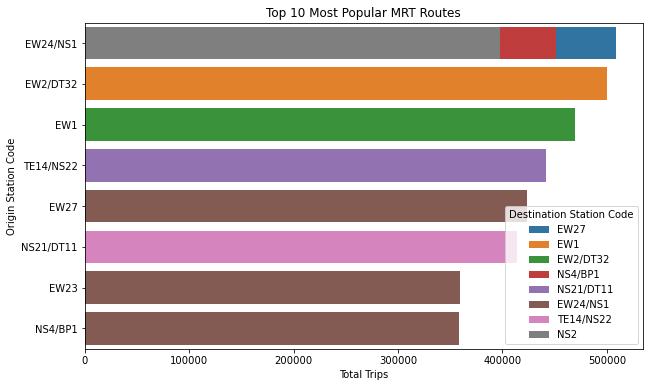

In [11]:
# Calculate the total number of trips for each route
route_counts = combined_df.groupby(['ORIGIN_PT_CODE', 'DESTINATION_PT_CODE'])['TOTAL_TRIPS'].sum().reset_index()

# Sort the routes by the total number of trips and get the top 10
top_routes = route_counts.sort_values(by='TOTAL_TRIPS', ascending=False).head(10)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=top_routes, x='TOTAL_TRIPS', y='ORIGIN_PT_CODE', hue='DESTINATION_PT_CODE', dodge=False)
plt.title('Top 10 Most Popular MRT Routes')
plt.xlabel('Total Trips')
plt.ylabel('Origin Station Code')
plt.legend(title='Destination Station Code')
plt.show()

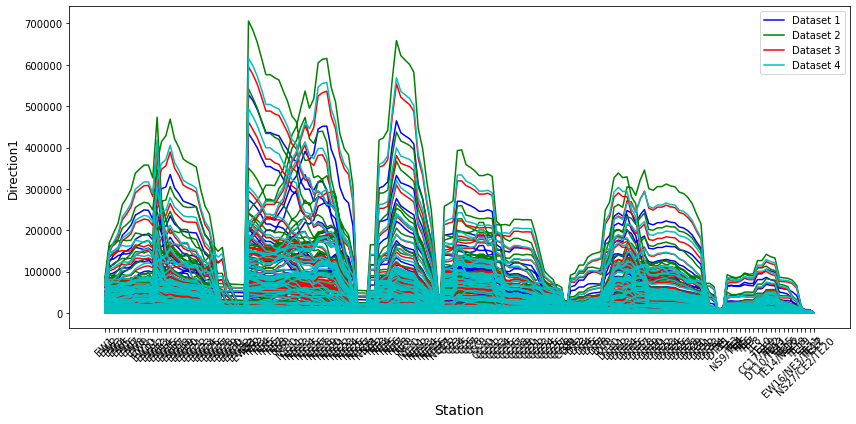

In [12]:
# data1 = data1[(data1['Station'].isin(EW_LINE)) & (data1['Time'] == 8) & (data1['WeekType'] == "WEEKDAY")]
# data2 = data2[(data2['Station'].isin(EW_LINE)) & (data2['Time'] == 8) & (data2['WeekType'] == "WEEKDAY")]
# data3 = data3[(data3['Station'].isin(EW_LINE)) & (data3['Time'] == 8) & (data3['WeekType'] == "WEEKDAY")]
# data4 = data4[(data4['Station'].isin(EW_LINE)) & (data4['Time'] == 8) & (data4['WeekType'] == "WEEKDAY")]

colors = ['b', 'g', 'r', 'c']  # blue, green, red, cyan
# Get station names (assuming consistent across DataFrames)
stations = data1['Station']

# Extract data for plotting (assuming same column name for actual values)
data_values = [df['Direction1'] for df in [data1, data2, data3, data4]]
# predicted_values = predictions['Predicted Direction1']  # Assuming column name
# Create the base plot
plt.figure(figsize=(12, 6))
plt.xticks(rotation=45)
plt.xlabel('Station', fontsize=14)
plt.ylabel('Direction1', fontsize=12)

# Plot actual values from each dataset with linestyles
for i, data in enumerate(data_values):
  plt.plot(stations, data, label=f'Dataset {i+1}', color=colors[i], linestyle='-')  # Solid line for actual values

# Plot predicted values with a different linestyle (e.g., dashed)
# plt.plot(stations, predicted_values, label='Predicted', color='black', linestyle='--')  # Dashed line for predictions

# Add legend to identify each dataset
plt.legend()

plt.tight_layout()
plt.show()


---
### **Machine Learning Techniques**:   (20%)         
We've selected an appropriate predictive modeling technique which is ARIMA - AutoRegressive Integrated Moving Average, a powerful time series forecasting model used to predict future values based on past observations.


ARIMA comprises of 3 components:

The first component, AutoRegressive uses the relationship between an observation and a number of lagged observations. In our context, it  looks at how past occupancy levels influence future occupancy.

The Second Component, Integrated refers to differencing the raw observations to make the time series stationary as it is crucial for ARIMA so as to remove trends or seasonality

The Last Component, Moving Average captures the relationship between the observation and the residual errors, which helps in modeling the randomness in the data.

### ARIMA (AutoRegressive Integrated Moving Average)

In [13]:
from statsmodels.tsa.arima.model import ARIMA
import warnings

# Filter warnings to ignore only UserWarnings & FutureWarning
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

dataframes = [data1, data2, data3, data4]

# Column names for station identifier and target value (adjust as needed)
station_col = "Station"
time_col = "Time"
value_col1 = "Direction1"
value_col2 = "Direction2"

# Create empty dictionary to store predicted values
predicted_values_d1 = {}
predicted_values_d2 = {}

# Calculate weights for each dataset
weights = [0.1, 0.15, 0.25, 0.5]

# Filter warnings to ignore only UserWarnings & FutureWarning
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

unique_day = ["WEEKDAY", "WEEKENDS/HOLIDAY"]
unique_time_slots = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]

predicted_data = pd.DataFrame(columns=['WeekType', 'Time', 'Station', 'Direction1', 'Direction2'])

for day in unique_day:
    for time_slot in unique_time_slots:
        for station in dataframes[0][station_col].unique():
            # Extract time series data for the station across all dataframes
            station_data = pd.concat([df[(df[station_col] == station) & (df[time_col] == time_slot)][value_col1] for df in dataframes], ignore_index=True)
            station_data_2 = pd.concat([df[(df[station_col] == station) & (df[time_col] == time_slot)][value_col2] for df in dataframes], ignore_index=True)
            # print(station_data)
            # Build and fit ARIMA model, predict for next month
            model = ARIMA(station_data, order=(0, 0, 4))  # Adjust order as needed
            model_fit = model.fit()
            forecast = math.ceil(model_fit.forecast(steps=1))  # Extract first element

            model2 = ARIMA(station_data_2, order=(0, 0, 4))  # Adjust order as needed
            model_fit2 = model2.fit()
            forecast2 = math.ceil(model_fit2.forecast(steps=1))  # Extract first element

            new_row = {'WeekType': day, 'Time': time_slot, 'Station': station, 'Direction1': forecast, 'Direction2': forecast2}
            # Append the new row to the new DataFrame
            new = pd.DataFrame([new_row])
            predicted_data = pd.concat([predicted_data, new], ignore_index=True)
            
        print(day, time_slot, " Done");

predicted_data.to_csv("202404_Prediction.csv")

WEEKDAY 0  Done
WEEKDAY 1  Done
WEEKDAY 2  Done
WEEKDAY 3  Done
WEEKDAY 4  Done
WEEKDAY 5  Done
WEEKDAY 6  Done
WEEKDAY 7  Done
WEEKDAY 8  Done
WEEKDAY 9  Done
WEEKDAY 10  Done
WEEKDAY 11  Done
WEEKDAY 12  Done
WEEKDAY 13  Done
WEEKDAY 14  Done
WEEKDAY 15  Done
WEEKDAY 16  Done
WEEKDAY 17  Done
WEEKDAY 18  Done
WEEKDAY 19  Done
WEEKDAY 20  Done
WEEKDAY 21  Done
WEEKDAY 22  Done
WEEKDAY 23  Done
WEEKENDS/HOLIDAY 0  Done
WEEKENDS/HOLIDAY 1  Done
WEEKENDS/HOLIDAY 2  Done
WEEKENDS/HOLIDAY 3  Done
WEEKENDS/HOLIDAY 4  Done
WEEKENDS/HOLIDAY 5  Done
WEEKENDS/HOLIDAY 6  Done
WEEKENDS/HOLIDAY 7  Done
WEEKENDS/HOLIDAY 8  Done
WEEKENDS/HOLIDAY 9  Done
WEEKENDS/HOLIDAY 10  Done
WEEKENDS/HOLIDAY 11  Done
WEEKENDS/HOLIDAY 12  Done
WEEKENDS/HOLIDAY 13  Done
WEEKENDS/HOLIDAY 14  Done
WEEKENDS/HOLIDAY 15  Done
WEEKENDS/HOLIDAY 16  Done
WEEKENDS/HOLIDAY 17  Done
WEEKENDS/HOLIDAY 18  Done
WEEKENDS/HOLIDAY 19  Done
WEEKENDS/HOLIDAY 20  Done
WEEKENDS/HOLIDAY 21  Done
WEEKENDS/HOLIDAY 22  Done
WEEKENDS/HOLID

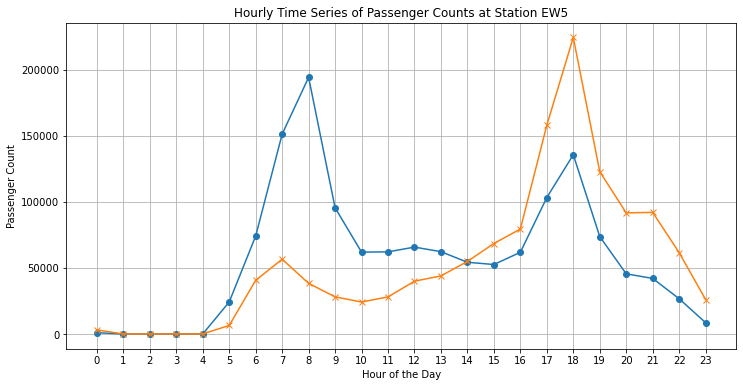

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your dataset into a pandas DataFrame
# Assuming your dataset is in a CSV file named 'train_data.csv'
data = pd.read_csv('202404_Prediction.csv')

# Choose a station code for which you want to plot the time series
station_code = 'EW5'

# Filter the dataset for the chosen station
station_data = data[(data['Station'] == station_code) & (data['WeekType'] == "WEEKENDS/HOLIDAY")]

# Plot time series of passenger counts for the chosen station
plt.figure(figsize=(12, 6))
plt.plot(station_data['Time'], station_data['Direction1'], marker='o', linestyle='-', label='Direction 1')
plt.plot(station_data['Time'], station_data['Direction2'], marker='x', linestyle='-', label='Direction 2')
plt.title('Hourly Time Series of Passenger Counts at Station {}'.format(station_code))
plt.xlabel('Hour of the Day')
plt.ylabel('Passenger Count')
plt.xticks(range(24))  # Ensure x-axis ticks are from 0 to 23
plt.grid(True)
plt.show()

In [26]:

##################################################################################################################
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings

# Filter warnings to ignore only UserWarnings & FutureWarning
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

dataframes = [data1, data2, data3, data4]

# Column names for station identifier and target value (adjust as needed)
station_col = "Station"
time_col = "Time"
value_col1 = "Direction1"
value_col2 = "Direction2"

# Create empty dictionary to store predicted values
predicted_values_d1 = {}
predicted_values_d2 = {}

# Calculate weights for each dataset
weights = [0.1, 0.15, 0.25, 0.5]

# Filter warnings to ignore only UserWarnings & FutureWarning
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

unique_day = ["WEEKDAY", "WEEKENDS/HOLIDAY"]
unique_time_slots = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]

predicted_data = pd.DataFrame(columns=['WeekType', 'Time', 'Station', 'Direction1', 'Direction2'])

for day in unique_day:
    for time_slot in unique_time_slots:
        for station in dataframes[0][station_col].unique():
            # Extract time series data for the station across all dataframes
            station_data = pd.concat([df[(df[station_col] == station) & (df[time_col] == time_slot)][value_col1] for df in dataframes], ignore_index=True)
            station_data_2 = pd.concat([df[(df[station_col] == station) & (df[time_col] == time_slot)][value_col2] for df in dataframes], ignore_index=True)
            # print(station_data)
            # Build and fit ARIMA model, predict for next month
            model = SARIMAX(station_data, order=(1, 0, 4))  # Adjust order as needed
            model_fit = model.fit()
            forecast = math.ceil(model_fit.forecast(steps=1))  # Extract first element

            model2 = SARIMAX(station_data_2, order=(1, 0, 4))  # Adjust order as needed
            model_fit2 = model2.fit()
            forecast2 = math.ceil(model_fit2.forecast(steps=1))  # Extract first element

            new_row = {'WeekType': day, 'Time': time_slot, 'Station': station, 'Direction1': forecast, 'Direction2': forecast2}
            # Append the new row to the new DataFrame
            new = pd.DataFrame([new_row])
            predicted_data = pd.concat([predicted_data, new], ignore_index=True)
            
        print(day, time_slot, " Done");

predicted_data.to_csv("202404_Prediction_SARIMA_1.csv")

WEEKDAY 0  Done
WEEKDAY 1  Done
WEEKDAY 2  Done
WEEKDAY 3  Done
WEEKDAY 4  Done
WEEKDAY 5  Done
WEEKDAY 6  Done
WEEKDAY 7  Done
WEEKDAY 8  Done
WEEKDAY 9  Done
WEEKDAY 10  Done
WEEKDAY 11  Done
WEEKDAY 12  Done
WEEKDAY 13  Done
WEEKDAY 14  Done
WEEKDAY 15  Done
WEEKDAY 16  Done
WEEKDAY 17  Done
WEEKDAY 18  Done
WEEKDAY 19  Done
WEEKDAY 20  Done
WEEKDAY 21  Done
WEEKDAY 22  Done
WEEKDAY 23  Done
WEEKENDS/HOLIDAY 0  Done
WEEKENDS/HOLIDAY 1  Done
WEEKENDS/HOLIDAY 2  Done
WEEKENDS/HOLIDAY 3  Done
WEEKENDS/HOLIDAY 4  Done
WEEKENDS/HOLIDAY 5  Done
WEEKENDS/HOLIDAY 6  Done
WEEKENDS/HOLIDAY 7  Done
WEEKENDS/HOLIDAY 8  Done
WEEKENDS/HOLIDAY 9  Done
WEEKENDS/HOLIDAY 10  Done
WEEKENDS/HOLIDAY 11  Done
WEEKENDS/HOLIDAY 12  Done
WEEKENDS/HOLIDAY 13  Done
WEEKENDS/HOLIDAY 14  Done
WEEKENDS/HOLIDAY 15  Done
WEEKENDS/HOLIDAY 16  Done
WEEKENDS/HOLIDAY 17  Done
WEEKENDS/HOLIDAY 18  Done
WEEKENDS/HOLIDAY 19  Done
WEEKENDS/HOLIDAY 20  Done
WEEKENDS/HOLIDAY 21  Done
WEEKENDS/HOLIDAY 22  Done
WEEKENDS/HOLID

In [28]:
# Read in the datasets
dataset1 = pd.read_csv("202312_Dataset.csv")
dataset2 = pd.read_csv("202401_Dataset.csv")
dataset3 = pd.read_csv("202402_Dataset.csv")
dataset4 = pd.read_csv("202403_Dataset.csv")

ARIMA = pd.read_csv("202404_Prediction.csv")
SARIMA = pd.read_csv("202404_Prediction_SARIMA_1.csv")

# Merge the datasets
merged_data = pd.concat([dataset1, dataset2, dataset3, dataset4], ignore_index=True)

# Merge based on index with a multi-level column index
result = pd.concat([ARIMA, SARIMA], axis=1,  keys=['ARIMA', 'SARIMA'])

result = result.drop(columns=[("ARIMA", "WeekType"), ("ARIMA", "Unnamed: 0"), ("ARIMA", "Time"), ("SARIMA", "Unnamed: 0"), ("SARIMA", "WeekType"), ("SARIMA", "Time")])

# Center the column index
result = result.style.set_table_styles([{'selector': 'th', 'props': [('text-align', 'center')]}])

# Display the styled dataframe
result

---
### **Data-driven insights**:        

We are able to predict the number of Passenger at each station across the 6 MRT Networks with the help of a Time Series ForeCasting Methods in which we chose ARIMA; AutoRegressive Integrated Moving Average as it has a more accurate value  in the number of Passengers at each station.

With ARIMA, commuters are able to make informed decision on which train to board, what time will the train be crowded and plan their journey ahead.

This addresses the problem of uncertain train occupancy which may cause discomfort for commuters

This will in turn improve the commuting experience for passengers.


### ComforTrain App
We then further Implement this into a simple Interface called ComforTrain as a basis for Users to try in which they are able to view the Passenger Load. 

In this App Demo, the user view the current load by Station in which he/ she input the current station and then receive the output on the number of passengers in both directions, the level of comfort and indicates whether there's limited seats or standing.


### **App Demo**:  

In [22]:
app_data = pd.read_csv("202404_Prediction.csv")

def comfortLevel(load):
    length = 32 - len(str(load))

    if load == 0:
        return "Comfort Level: N/A (No Train Service) "
    elif load < 100:
        return "Comfort Level: Excellent              "
    elif load < 200:
        return "Comfort Level: Very Good              "
    elif load < 400:
        return "Comfort Level: Good                   "
    elif load < 750:
        return "Comfort Level: Bad                    "
    else:
        return "Comfort Level: Very Bad               "


def appLoader():

    while True:
        print("┌────────────────────────────────────────┐")
        print("|         Welcome to ComforTrain         |")
        print("|                                        |")
        print("| 1. View Current Load by Station        |")
        print("| 2. View Current Load by Line           |")
        print("|                                        |")
        print("|           Enter your choice            |")
        print("└────────────────────────────────────────┘")
        print()

        choice = int(input("Select choice from the menu: "))

        if choice == 1:
            stationSelector()
            break
        elif choice == 2:
            lineSelector()
            break


def timeFormatter(time):
    if time < 10:
        return "0" + str(time)
    else:
        return str(time)


def stationFormatter(list, list_name, station):
    length = 28
    return (
        list[station]
        + " "
        + list_name[station]
        + (" " * (length - len(list[station]) - len(list_name[station])))
    )


def lineFormatter(list, station):
    length = 31 - len(list[0]) - len(list[-1])

    ratio = math.floor(((station / len(list)) * length))
    return (
        list[0]
        + " ◁"
        + ("─" * (ratio))
        + "●"
        + ("─" * (length - ratio))
        + "▷ "
        + list[-1]
    )


def loadFormatter(load):
    length = 32 - len(str(load))

    if load == 0:
        return "        N/A (No Train Service)        "
    elif load < 100:
        length -= 18
        return "Load: " + str(load) + " (Seats Available)" + (" " * length)
    elif load < 200:
        length -= 16
        return "Load: " + str(load) + " (Limited Seats)" + (" " * length)
    elif load < 400:
        length -= 21
        return "Load: " + str(load) + " (Standing Available)" + (" " * length)
    elif load < 750:
        length -= 19
        return "Load: " + str(load) + " (Limited Standing)" + (" " * length)
    else:
        length -= 27
        return "Load: " + str(load) + " (Better to Skip Trains...)" + (" " * length)


def stationSelector():

    print("┌────────────────────────────────────────┐")
    print("|         Welcome to ComforTrain         |")
    print("|                                        |")
    print("| 1. View Current Load by Station        |")
    print("|                                        |")
    print("|         Enter the Station Code         |")
    print("└────────────────────────────────────────┘")
    print()

    while True:
        station = input("Enter the station code of the platform: ")

        if station.startswith("EW"):
            list = EW_STATIONS
            list_name = EW_STATIONS_NAME
            list_id = EW_LINE
            station_code = int(station[2:])
            if station_code <= len(list):
                break
        elif station.startswith("NS"):
            list = NS_STATIONS
            list_name = NS_STATIONS_NAME
            list_id = NS_LINE
            station_code = int(station[2:])
            if station_code <= len(list):
                break
        elif station.startswith("NE"):
            list = NE_STATIONS
            list_name = NE_STATIONS_NAME
            list_id = NE_LINE
            station_code = int(station[2:])
            if station_code <= len(list):
                break
        elif station.startswith("CC"):
            list = CC_STATIONS
            list_name = CC_STATIONS_NAME
            list_id = CC_LINE
            station_code = int(station[2:])
            if station_code <= len(list):
                break
        elif station.startswith("DT"):
            list = DT_STATIONS
            list_name = DT_STATIONS_NAME
            list_id = DT_LINE
            station_code = int(station[2:])
            if (station_code <= len(list)):
                break
        elif station.startswith("TE"):
            list = TE_STATIONS
            list_name = TE_STATIONS_NAME
            list_id = TE_LINE
            station_code = int(station[2:])
            if station_code <= len(list):
                break

     # Get current date and time
    current_datetime = datetime.datetime.now()

    # Extract hour and day
    current_hour = current_datetime.hour
    current_day = current_datetime.weekday()

    day_type = ["WEEKDAY",  "WEEKDAY",  "WEEKDAY",  "WEEKDAY",  "WEEKDAY", "WEEKENDS/HOLIDAY", "WEEKENDS/HOLIDAY"][current_day]
    day_count = [240, 240, 240, 240, 240, 96, 96][current_day]

    if current_datetime.minute < 45:
        current_hour = current_hour
    else:
        current_hour = (current_hour + 1) % 24

    if (current_hour == 0) or (5 <= current_hour <= 24):

        station_data = app_data[(app_data["Time"] == current_hour) & (app_data["WeekType"] == day_type) & (app_data["Station"] == station)]

        print("┌────────────────────────────────────────┐")
        print("|      Predicted Train Load @ " + timeFormatter(current_hour) + ":00      |")
        print("|                                        |")
        print("|  " + lineFormatter(list, station_code) + "  |")
        print("| Current: " + stationFormatter(list, list_name, station_code - 1) + " |")
        print("|                                        |")
        print("| Towards: " + stationFormatter(list, list_name, 0) + " |")
        print("| " + loadFormatter(math.ceil(station_data["Direction2"] / (day_count))) + " |")
        print("| " + comfortLevel(math.ceil(station_data["Direction2"] / (day_count))) + " |")
        print("|                                        |")
        print("| Towards: " + stationFormatter(list, list_name, -1) + " |")
        print("| " + loadFormatter(math.ceil(station_data["Direction1"] / (day_count))) + " |")
        print("| " + comfortLevel(math.ceil(station_data["Direction1"] / (day_count))) + " |")
        print("└────────────────────────────────────────┘")
    else:
        print("┌────────────────────────────────────────┐")
        print("|                 Alert!                 |")
        print("|                                        |")
        print("|  There are no train services running!  |")
        print("|                                        |")
        print("└────────────────────────────────────────┘")

def lineSelector():

    print("┌────────────────────────────────────────┐")
    print("|         Welcome to ComforTrain         |")
    print("|                                        |")
    print("| 2. View Current Load by Line           |")
    print("|                                        |")
    print("|         Enter the Line Prefix          |")
    print("└────────────────────────────────────────┘")
    print()

    while True:
        station = input("Enter the line prefix of the platform: ")

        if station.startswith("EW"):
            list = EW_STATIONS
            list_name = EW_STATIONS_NAME
            list_id = EW_LINE
            break
        elif station.startswith("NS"):
            list = NS_STATIONS
            list_name = NS_STATIONS_NAME
            list_id = NS_LINE
            break
        elif station.startswith("NE"):
            list = NE_STATIONS
            list_name = NE_STATIONS_NAME
            list_id = NE_LINE
            break
        elif station.startswith("CC"):
            list = CC_STATIONS
            list_name = CC_STATIONS_NAME
            list_id = CC_LINE
            break
        elif station.startswith("DT"):
            list = DT_STATIONS
            list_name = DT_STATIONS_NAME
            list_id = DT_LINE
            break
        elif station.startswith("TE"):
            list = TE_STATIONS
            list_name = TE_STATIONS_NAME
            list_id = TE_LINE
            break

    # Get current date and time
    current_datetime = datetime.datetime.now()

    # Extract hour and day
    current_hour = current_datetime.hour
    current_day = current_datetime.weekday()

    day_type = ["WEEKDAY",  "WEEKDAY",  "WEEKDAY",  "WEEKDAY",  "WEEKDAY", "WEEKENDS/HOLIDAY", "WEEKENDS/HOLIDAY"][current_day]
    day_count = [240, 240, 240, 240, 240, 96, 96][current_day]

    if current_datetime.minute < 45:
        current_hour = current_hour
    else:
        current_hour = (current_hour + 1) % 24

    if (current_hour == 0) or (5 <= current_hour <= 24):
        
        print("┌────────────────────────────────────────┐")
        print("|                                        |")
        print("|      Predicted Train Load @ " + timeFormatter(current_hour) + ":00      |")
        print("|                                        |")
        print("└────────────────────────────────────────┘")

        for station in list_id:
            station1_data = app_data[(app_data["Time"] == current_hour) & (app_data["WeekType"] == day_type) & (app_data["Station"] == station)]
            if(list_id.index(station) < len(list_id)-1):
                station2_data = app_data[(app_data["Time"] == current_hour) & (app_data["WeekType"] == day_type) & (app_data["Station"] == list_id[list_id.index(station)+1])]
                load2 = (11 - len(str(math.ceil(station2_data["Direction2"] / (day_count)))))
            # main1A, main1B = loadCalculator(current_hour, list, list.index(station)+1)
            # main2A, main2B = loadCalculator(current_hour, list, list.index(station)+2)
            
            load1 = (11 - len(str(math.ceil(station1_data["Direction1"] / (day_count)))))
            

            station_centralizer = (34 - len(list_id[list_id.index(station)])) / 2;

            print((" " * math.ceil(station_centralizer)), list_id[list_id.index(station)], (" " * math.floor(station_centralizer)))
            if(list_id.index(station) < len(list_id)-1):
                print((" " * math.ceil(load1)), str(math.ceil(station1_data["Direction1"] / (day_count))), " ⬇    ⬆ ", str(math.ceil(station2_data["Direction2"] / (day_count))) , (" " * math.ceil(load2)))
        
        # for station in list_id:
        #     station_data = app_data[(app_data["Time"] == current_hour) & (app_data["WeekType"] == "WEEKDAY") & (app_data["Station"] == station)]
        #     load1 = (12 - len(str(math.ceil(station_data["Direction1"] / (240)))))/2
        #     load2 = (12 - len(str(math.ceil(station_data["Direction2"] / (240)))))/2
        #     print("| " + station[:12] + (" " * (12 - len(station[:12]))) + "|" + (" " * math.floor(load2)) + str(math.ceil(station_data["Direction2"] / (240))) + (" " * math.ceil(load2)) + "|" + (" " * math.floor(load1)) + str(math.ceil(station_data["Direction1"] / (240))) + (" " * math.ceil(load1)) + " |")
    else:
        print("┌────────────────────────────────────────┐")
        print("|                 Alert!                 |")
        print("|                                        |")
        print("|  There are no train services running!  |")
        print("|                                        |")
        print("└────────────────────────────────────────┘")


appLoader()


┌────────────────────────────────────────┐
|         Welcome to ComforTrain         |
|                                        |
| 1. View Current Load by Station        |
| 2. View Current Load by Line           |
|                                        |
|           Enter your choice            |
└────────────────────────────────────────┘



Select choice from the menu:  2


┌────────────────────────────────────────┐
|         Welcome to ComforTrain         |
|                                        |
| 2. View Current Load by Line           |
|                                        |
|         Enter the Line Prefix          |
└────────────────────────────────────────┘



Enter the line prefix of the platform:  DTL


┌────────────────────────────────────────┐
|                                        |
|      Predicted Train Load @ 22:00      |
|                                        |
└────────────────────────────────────────┘
                 DT1                
          11  ⬇    ⬆  114         
                 DT2                
          11  ⬇    ⬆  119         
                 DT3                
          13  ⬇    ⬆  126         
                 DT4                
          13  ⬇    ⬆  126         
                 DT5                
          14  ⬇    ⬆  169         
                 DT6                
          22  ⬇    ⬆  178         
                 DT7                
          24  ⬇    ⬆  183         
                 DT8                
          23  ⬇    ⬆  187         
                 DT9                
          74  ⬇    ⬆  184         
                DT10                
          95  ⬇    ⬆  188         
                DT11                
         152  ⬇    ⬆  234   

---
### **Future Possiblities**:       

Moving Forward with what we have implemented with a simple interface of ComforTrain.

Some of the recommendations that could be implemented are to further improve commuters experience:

Firstly, to predict the occupancy in each carriage of the train. This is to maximize the space of the train for commuters to travel and evenly distribute the commuters across the carriages of the train. This could be done by real-time feed camera in each platform doors where commuters go into which carriage.

Secondly, at current, our predictions are at an hourly time interval. Predictions at smaller interval will overall provide a more accurate result over a shorter period of time that will improve commuters experience.

Thirdly, most if not all commuters wishes to seat, Having a prediction for the number of standing or seating slots would also improve commuters experience.

Lastly, is to bring upscale this project to include public buses, LRTs etc. which too encompasses the Singapore's Public System

An interesting idea, is to actually turn the Interface ComforTrain into an actual application for commuters to download and utilise at the tip of their fingertips!

With an application, it provides easy access to train occupancy information anytime, anywhere making it convenient for commuters!

Furthermore, it can provide them with real-time information on train occupancy, allowing them to make informed decisions about when to travel and which trains to take. 

This will in turn lessen the issue of overcrowding trains which can improve travel experiences.


---
### **References**:            


In [ ]:
1. https://datamall.lta.gov.sg/content/dam/datamall/datasets/LTA_DataMall_API_User_Guide.pdf